In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(1/3/np.pi)
r2 = np.sqrt((1/3/np.pi+r1**2))
r1, r2

(0.32573500793527993, 0.46065886596178063)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of

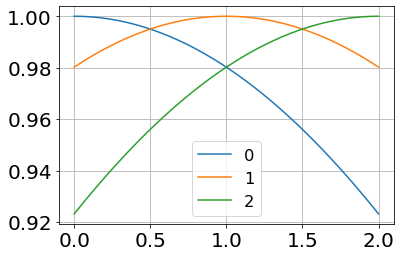

In [10]:
xx = np.linspace(0,2,num = 100000)
p0 = np.exp(-xx**2/(2*5**2))
p1 = np.exp(-(xx-1)**2/(2*5**2))
p2 = np.exp(-(xx-2)**2/(2*5**2))

fig, ax  = plt.subplots(1,1)
ax.plot(xx, p0)
ax.plot(xx, p1)
ax.plot(xx, p2)
ax.legend(['0','1','2'])
ax.grid(visible = True)
fig.show()


In [11]:
%%time
path_figs = './figs/2Mstd5/'
save = False
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 0 ns, sys: 564 µs, total: 564 µs
Wall time: 940 µs


In [12]:
N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.325735]
r_big = [0.325735,0.46065886]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000


In [13]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305
2,0.423655,0.645894,2,0,12.765129,3.450364,-9.314765
3,0.437587,0.891773,1,1,-8.255978,-0.477820,-7.778159
4,0.963663,0.383442,0,0,9.189899,3.188290,-6.001609


In [14]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,1.000020e+00,5.001005e-01,8.330335e-01,8.404234e-01,1.003147e+00
std,2.887267e-01,2.886267e-01,8.164207e-01,5.000001e-01,5.045290e+00,5.047374e+00,7.113687e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-2.559529e+01,-2.292883e+01,-3.242735e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-2.568211e+00,-2.569452e+00,-3.791629e+00
50%,4.999703e-01,5.003810e-01,1.000000e+00,1.000000e+00,8.355991e-01,8.383376e-01,9.974728e-01
75%,7.499998e-01,7.500191e-01,2.000000e+00,1.000000e+00,4.233814e+00,4.248720e+00,5.803340e+00
max,9.999993e-01,9.999997e-01,2.000000e+00,1.000000e+00,2.612381e+01,2.604293e+01,3.584543e+01


In [15]:
data['C'].value_counts()/len(data)

1    0.333458
2    0.333281
0    0.333261
Name: C, dtype: float64

In [16]:
data.groupby('C').ITE.mean()

C
0    0.004805
1    1.000390
2    2.004189
Name: ITE, dtype: float64

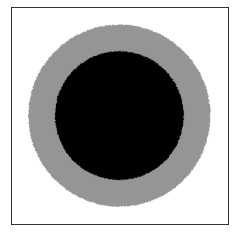

In [56]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)
ax.set_aspect('equal', adjustable='box')

ax.set_xticks([])
ax.set_yticks([])
fig.savefig(ppp+'data.jpeg',bbox_inches='tight', pad_inches = 0.1)

plt.show()

In [18]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305
2,0.423655,0.645894,2,0,12.765129,3.450364,-9.314765
3,0.437587,0.891773,1,1,-8.255978,-0.477820,-7.778159
4,0.963663,0.383442,0,0,9.189899,3.188290,-6.001609


### Apply clustering Box and Kmeans

In [20]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 140 ms, sys: 280 ms, total: 420 ms
Wall time: 418 ms


In [21]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,982
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,762
2,0.423655,0.645894,2,0,12.765129,3.450364,-9.314765,866
3,0.437587,0.891773,1,1,-8.255978,-0.477820,-7.778159,1200
4,0.963663,0.383442,0,0,9.189899,3.188290,-6.001609,553


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [22]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)



In [23]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,0.134381,1409.0,1.0,0.000705
1,1,0.062804,1451.0,1.0,0.000726
2,2,-0.101859,1399.0,1.0,0.000700


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


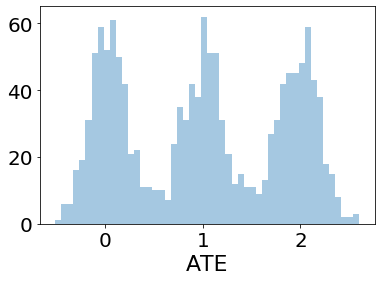

In [24]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 50
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



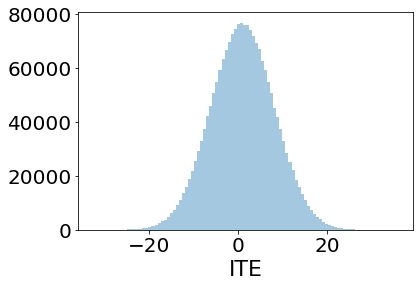

In [25]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = 100,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [26]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,1369.00000,1369.000000,1369.000000,1369.000000,1369.000000
mean,684.00000,1.003310,1460.920380,0.961037,0.000730
std,395.34057,0.822437,37.097551,0.116090,0.000019
min,0.00000,-0.515984,1345.000000,0.500666,0.000673
25%,342.00000,0.154030,1435.000000,1.000000,0.000718
50%,684.00000,1.012108,1460.000000,1.000000,0.000730
75%,1026.00000,1.827585,1486.000000,1.000000,0.000743
max,1368.00000,2.604595,1590.000000,1.000000,0.000795


In [27]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2']
names_to_find= ['Box-ATT']

weights = ['Box-Weights']

clusts = 3
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N )
    


Did not pick 3, it picked: 0
CPU times: user 934 ms, sys: 43.4 ms, total: 977 ms
Wall time: 2.02 s


In [28]:
box

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.134381,1409.0,1.0,0.000705,0
1,1,0.062804,1451.0,1.0,0.000726,0
2,2,-0.101859,1399.0,1.0,0.000700,0
3,3,0.137937,1390.0,1.0,0.000695,0
4,4,0.102957,1489.0,1.0,0.000745,0
...,...,...,...,...,...,...
1364,1364,-0.039886,1486.0,1.0,0.000743,0
1365,1365,-0.043967,1409.0,1.0,0.000705,0
1366,1366,0.227997,1459.0,1.0,0.000730,0
1367,1367,0.042354,1447.0,1.0,0.000723,0


In [29]:
box['Box-Cl2'].value_counts()

0    462
2    456
1    451
Name: Box-Cl2, dtype: int64

In [30]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.134381,1409.0,1.0,0.000705,0
1,1,0.062804,1451.0,1.0,0.000726,0


In [31]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,982
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,762


### 3 Clustering in the ITEs

In [32]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2



#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [33]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster']
class_names = ['Box-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name,'Box-ATT']]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [34]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster,ITE-2CTrue,Box-Cl2,Box-ATT
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,982,0,2,1.946575
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,762,2,2,1.932924


### Plot reconstruction of data

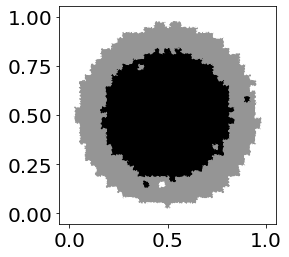

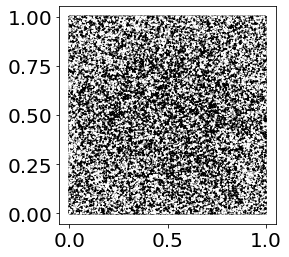

CPU times: user 1min 38s, sys: 2.03 s, total: 1min 40s
Wall time: 1min 37s


In [35]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2','ITE-2CTrue']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    ax.set_aspect('equal', adjustable='box')

    if save:
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [36]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [37]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [38]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [39]:
errors.sort_values(by = 'mean')

,mean,std
Box-Cl2-err-True-ITE,0.065532,0.205164
ITE-2CTrue-err-True-ITE,5.623850,1.447520


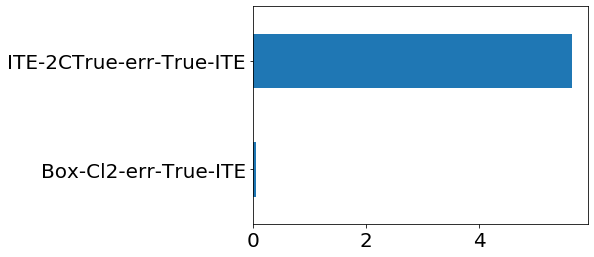

In [40]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [41]:
from evaluations import confusion_matrix
    

In [42]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name, 3, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.967411,0.032589,0.000000
C1 True,0.045307,0.923161,0.031532
C2 True,0.000000,0.032465,0.967535


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.528022,0.055764,0.416214
C1 True,0.472453,0.056530,0.471017
C2 True,0.415897,0.055657,0.528446


### Plots for presentation

In [43]:
data2.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster,ITE-2CTrue,Box-Cl2,Box-ATT,Box-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE
0,0.548814,0.715189,2,0,6.658786,-6.884317,-13.543103,982,0,2,1.946575,0.018207,6.992443
1,0.602763,0.544883,2,0,0.805499,2.984804,2.179305,762,2,2,1.932924,0.018207,5.002035
2,0.423655,0.645894,2,0,12.765129,3.450364,-9.314765,866,0,2,1.944095,0.018207,6.992443
3,0.437587,0.891773,1,1,-8.255978,-0.477820,-7.778159,1200,0,1,1.032155,0.004679,5.992443
4,0.963663,0.383442,0,0,9.189899,3.188290,-6.001609,553,0,0,-0.081320,0.036151,4.992443


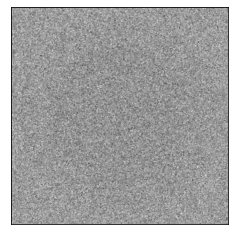

In [57]:
ppp = 'present/'
fig, ax = plt.subplots()
ite_names = 'ITE'
ax.scatter(data['x0'].values, data['x1'].values, c=data[ite_names].values, cmap = 'Greys', s=0.1)
ax.margins(0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')
fig.savefig(ppp+'pure_ite'+'.jpeg', bbox_inches='tight',pad_inches = 0.1)


In [51]:
ticks = np.linspace(0,1,x, endpoint = False)

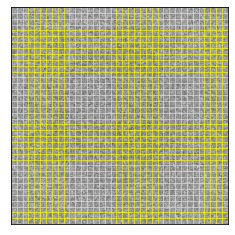

In [58]:
color = 'yellow'
alpha = 0.6
wd = 1
fig, ax = plt.subplots()
ite_names = 'ITE'
for tc in ticks:
    ax.axvline(x=tc, color =color, alpha = alpha, linestyle = '-', linewidth = wd)
    ax.axhline(y=tc, color = color, alpha = alpha, linestyle = '-', linewidth = wd)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(data['x0'].values, data['x1'].values, c=data[ite_names].values, cmap = 'Greys', s=0.1)

ax.margins(0)
ax.set_aspect('equal', adjustable='box')
fig.savefig(ppp+'boxed_ite'+'.jpeg', bbox_inches='tight',pad_inches = 0.1)


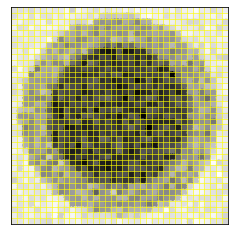

In [59]:
fig, ax = plt.subplots()
att_name = 'Box-ATT'
for tc in ticks:
    ax.axvline(x=tc, color =color, alpha = alpha, linestyle = '-', linewidth = wd)
    ax.axhline(y=tc, color = color, alpha = alpha, linestyle = '-', linewidth = wd)
ax.set_xticks([])
ax.set_yticks([])
    
ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[att_name].values, cmap = 'Greys', s=0.1)
ax.margins(0)
ax.set_aspect('equal', adjustable='box')
fig.savefig(ppp+'boxed_att'+'.jpeg', bbox_inches='tight',pad_inches = 0.1)


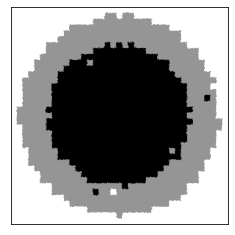

In [60]:
fig, ax = plt.subplots()
class_name = 'Box-Cl2'
#for tc in ticks:
    #ax.axvline(x=tc, color =color, alpha = alpha, linestyle = '-', linewidth = wd)
    #ax.axhline(y=tc, color = color, alpha = alpha, linestyle = '-', linewidth = wd)
ax.set_xticks([])
ax.set_yticks([])
    
ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[class_name].values, cmap = 'Greys', s=0.1)
ax.margins(0)
ax.set_aspect('equal', adjustable='box')
fig.savefig(ppp+'class_pred'+'.jpeg', bbox_inches='tight',pad_inches = 0.1)
